# Library Imports


In [10]:
# For the creation of models
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


# Data optimization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision

# Moving files into folders
import os
import shutil

# Splitting data
from sklearn.model_selection import train_test_split

# Graphing
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Download the Medical MNIST dataset from personal github
!wget https://github.com/sam-lara/CECS456_Project/raw/main/MedicalMNIST.zip

--2024-12-18 20:22:29--  https://github.com/sam-lara/CECS456_Project/raw/main/MedicalMNIST.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sam-lara/CECS456_Project/main/MedicalMNIST.zip [following]
--2024-12-18 20:22:30--  https://raw.githubusercontent.com/sam-lara/CECS456_Project/main/MedicalMNIST.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88933634 (85M) [application/zip]
Saving to: ‘MedicalMNIST.zip’

MedicalMNIST.zip    100%[===================>]  84.81M   367MB/s    in 0.2s    

2024-12-18 20:22:32 (367 MB/s) - ‘MedicalMNIST.zip’ saved [88933634/88933634]



In [3]:
# unzip files into a new folder
!unzip MedicalMNIST.zip -d ./MedicalMNST

Streaming output truncated to the last 5000 lines.
  inflating: ./MedicalMNST/HeadCT/005000.jpeg  
  inflating: ./MedicalMNST/HeadCT/005001.jpeg  
  inflating: ./MedicalMNST/HeadCT/005002.jpeg  
  inflating: ./MedicalMNST/HeadCT/005003.jpeg  
  inflating: ./MedicalMNST/HeadCT/005004.jpeg  
  inflating: ./MedicalMNST/HeadCT/005005.jpeg  
  inflating: ./MedicalMNST/HeadCT/005006.jpeg  
  inflating: ./MedicalMNST/HeadCT/005007.jpeg  
  inflating: ./MedicalMNST/HeadCT/005008.jpeg  
  inflating: ./MedicalMNST/HeadCT/005009.jpeg  
  inflating: ./MedicalMNST/HeadCT/005010.jpeg  
  inflating: ./MedicalMNST/HeadCT/005011.jpeg  
  inflating: ./MedicalMNST/HeadCT/005012.jpeg  
  inflating: ./MedicalMNST/HeadCT/005013.jpeg  
  inflating: ./MedicalMNST/HeadCT/005014.jpeg  
  inflating: ./MedicalMNST/HeadCT/005015.jpeg  
  inflating: ./MedicalMNST/HeadCT/005016.jpeg  
  inflating: ./MedicalMNST/HeadCT/005017.jpeg  
  inflating: ./MedicalMNST/HeadCT/005018.jpeg  
  inflating: ./MedicalMNST/HeadCT/005

In [4]:
# ensure reproducibility
np.random.seed(42)

# path of folder containing the images
original_dir = './MedicalMNST'

# Create directories for training, validation, and test sets
train_dir = './train'
val_dir = './validation'
test_dir = './test'

# create a list of all classes in the data set
classes = os.listdir(original_dir)

for class_name in classes:
    class_path = os.path.join(original_dir, class_name)

    # make folders for training, validation, and testing sets
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get a list of all images in the current class folder
    all_images = os.listdir(class_path)

    # Split data 80 - 20, for training and testing respectively
    train_images, test_val_images = train_test_split(all_images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

    # Move images to respective directories
    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


In [5]:
# Paths for data set folders
train_dir = "./train"
val_dir = "./validation"
test_dir = "./test"

# Data Generators - only load 128 images at a time to help with memory issues
batch_size = 128

train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=batch_size, class_mode="sparse"
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=batch_size, class_mode="sparse"
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=batch_size, class_mode="sparse", shuffle=False
)

Found 47163 images belonging to 6 classes.
Found 5895 images belonging to 6 classes.
Found 5896 images belonging to 6 classes.


In [6]:
# helper function to add residual blocks to the
def residual_block(x, filters):
    return ReLU()(Add()([
        Conv2D(filters, (3, 3), padding='same')(BatchNormalization()(x)),
        Conv2D(filters, (3, 3), padding='same')(BatchNormalization()(ReLU()(x))),
    ]))

def build_model(input_shape=(150, 150, 3), num_classes=6):
    inputs = Input(shape=input_shape)

    # take care of first layer separately
    conv1 = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    conv1_bn = BatchNormalization()(conv1)
    conv1_relu = ReLU()(conv1_bn)

    # Max Pooling after Convolution
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv1_relu)

    # Residual Blocks and Pooling for Downsampling
    for filters in [64, 128, 256, 512]:
        x = residual_block(x, filters)
        x = MaxPooling2D((2, 2), padding='same')(x)  # Downsampling

    # Global Pooling and Fully Connected Layer
    x = Dense(256, activation='relu')(GlobalAveragePooling2D()(x))

    # Final layer no activation function
    x = Dense(num_classes)(x)

    return Model(inputs, x)

# Build and compile the model
model = build_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 75, 75, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 75, 75, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 75, 75, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 38, 38, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 38, 38, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 38, 38, 64)     │            256 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 38, 38, 64)     │            256 │ re_lu_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 38, 38, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 38, 38, 64)     │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 38, 38, 64)     │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 38, 38, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 19, 19, 64)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 19, 19, 64)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 19, 19, 64)     │            256 │ max_pooling2d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 19, 19, 64)     │            256 │ re_lu_4[0][0]          │
│ (BatchNormalization) 

 Total params: 3,318,918 (12.66 MB)

 Trainable params: 3,316,742 (12.65 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [7]:
# train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


369/369 ━━━━━━━━━━━━━━━━━━━━ 75s 143ms/step - accuracy: 0.9449 - loss: 0.2269 - val_accuracy: 0.7708 - val_loss: 2.3764
Epoch 2/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9962 - loss: 0.0158 - val_accuracy: 0.9973 - val_loss: 0.0104
Epoch 3/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9965 - loss: 0.0183 - val_accuracy: 0.9969 - val_loss: 0.0135
Epoch 4/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9980 - loss: 0.0069 - val_accuracy: 0.7242 - val_loss: 4.5932
Epoch 5/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9975 - loss: 0.0104 - val_accuracy: 0.9978 - val_loss: 0.0044


In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
predictions = model.predict(test_generator, verbose=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9993 - loss: 0.0030
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step


In [11]:
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Display evaluation results
print(f"Test Accuracy: {100 * test_acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Test Accuracy: 99.8474

Classification Report:
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      1000
   BreastMRI       1.00      1.00      1.00       896
         CXR       1.00      1.00      1.00      1000
     ChestCT       1.00      1.00      1.00      1000
        Hand       1.00      0.99      1.00      1000
      HeadCT       1.00      1.00      1.00      1000

    accuracy                           1.00      5896
   macro avg       1.00      1.00      1.00      5896
weighted avg       1.00      1.00      1.00      5896



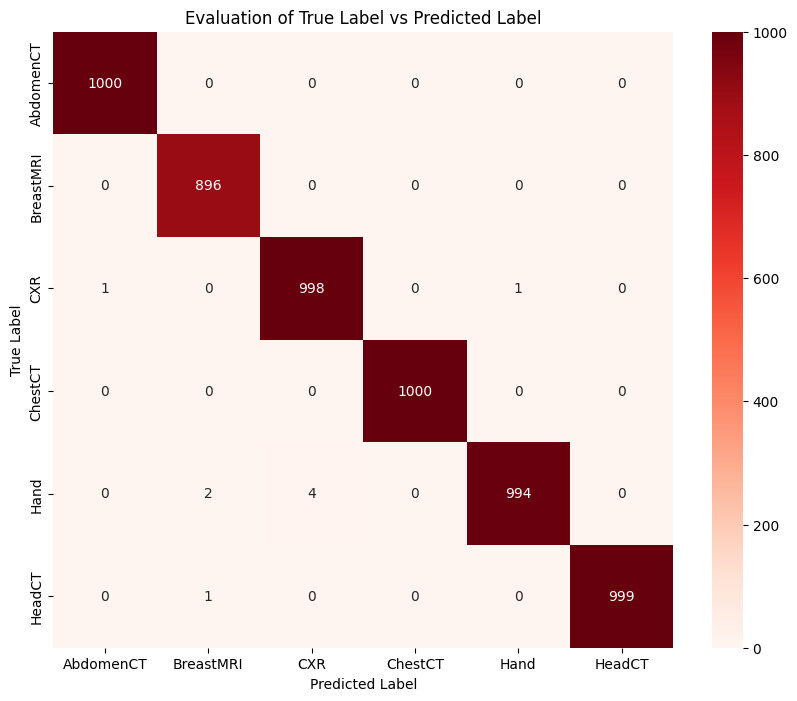

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Evaluation of True Label vs Predicted Label")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

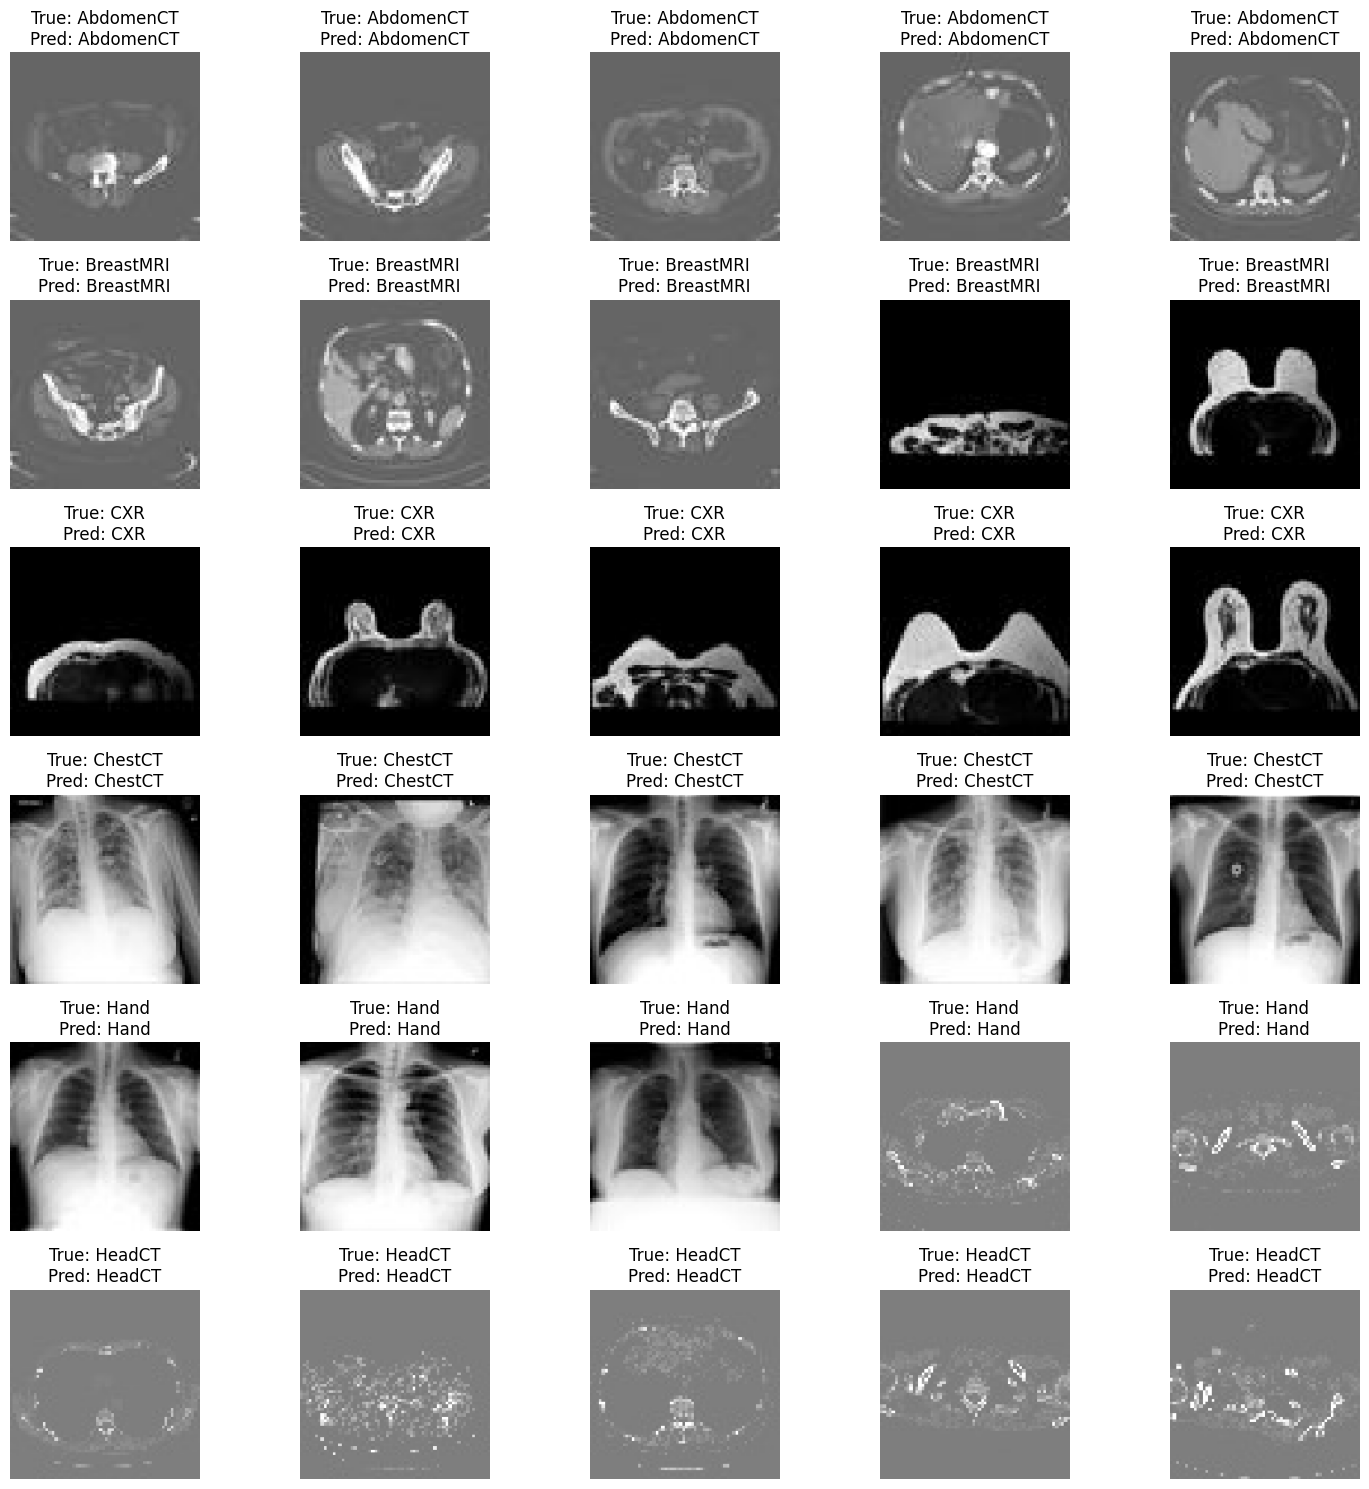

In [13]:
# Get the true labels for the images
true_labels = test_generator.classes

num_classes = len(class_labels)

fig, axes = plt.subplots(num_classes, 5, figsize=(15, 15))

# Loop through each class
for i in range(num_classes):
    class_indices = np.where(true_labels == i)[0]
    np.random.shuffle(class_indices)

    for j in range(5):
        idx = class_indices[j]

        # get the batch where the image is located
        batch_idx = idx // test_generator.batch_size
        batch_start = batch_idx * test_generator.batch_size
        batch_end = batch_start + test_generator.batch_size
        batch_images, batch_labels = next(test_generator)

        # Get the image and the predicted label
        img = batch_images[idx % test_generator.batch_size]
        true_label = class_labels[true_labels[idx]]
        predicted_label = class_labels[np.argmax(predictions[idx])]

        # Plot the image
        ax = axes[i, j]
        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
        ax.axis("off")

plt.tight_layout()
plt.show()
